# Twitter Sentiment Analysis

In [86]:
# !pip install gensim --upgrade
# !pip install keras --upgrade
# !pip install pandas --upgrade

In [87]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [88]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [89]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "(@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+)"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [90]:
dataset_filename = os.listdir("../input")[0]
dataset_path = os.path.join("..","input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ../input/training.1600000.processed.noemoticon.csv


In [91]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [92]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [93]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [94]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 823 ms, sys: 671 µs, total: 823 ms
Wall time: 824 ms


Text(0.5,1,'Dataset labels distribuition')

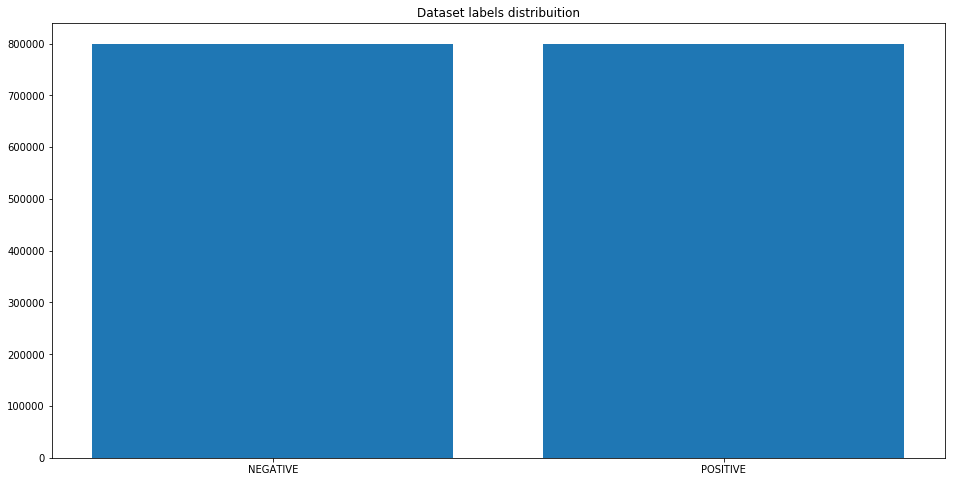

In [95]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [96]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [97]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [98]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min 4s, sys: 129 ms, total: 1min 4s
Wall time: 1min 4s


In [99]:
df.head() 

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see


In [100]:
#df2.loc[(df['target'] == 'TheComeback Trail')| (df['target'] ==  'Robert De Niro') ]
df3 = df[df['text'].str.contains( 'Movie', regex=False, case=False, na=False)]
print(df3.shape)
df4 = df[df['text'].str.contains( 'serie', regex=False, case=False, na=False)]
print(df4.shape)

dfull=df4.append(df3)
dfull.head()
print(dfull.shape)

(16282, 6)
(1529, 6)
(17811, 6)


### Split train and test

In [101]:
df_train, df_test = train_test_split(dfull, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 14248
TEST size: 3563


### Word2Vec 

In [102]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 220 ms, sys: 29.4 ms, total: 249 ms
Wall time: 248 ms


In [103]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [104]:
w2v_model.build_vocab(documents)

2021-09-19 19:38:55,228 : INFO : collecting all words and their counts
2021-09-19 19:38:55,230 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-09-19 19:38:55,256 : INFO : PROGRESS: at sentence #10000, processed 92363 words, keeping 12407 word types
2021-09-19 19:38:55,267 : INFO : collected 15324 word types from a corpus of 131310 raw words and 14248 sentences
2021-09-19 19:38:55,268 : INFO : Loading a fresh vocabulary
2021-09-19 19:38:55,282 : INFO : effective_min_count=10 retains 1517 unique words (9% of original 15324, drops 13807)
2021-09-19 19:38:55,282 : INFO : effective_min_count=10 leaves 105097 word corpus (80% of original 131310, drops 26213)
2021-09-19 19:38:55,290 : INFO : deleting the raw counts dictionary of 15324 items
2021-09-19 19:38:55,291 : INFO : sample=0.001 downsamples 55 most-common words
2021-09-19 19:38:55,292 : INFO : downsampling leaves estimated 78553 word corpus (74.7% of prior 105097)
2021-09-19 19:38:55,298 : INFO : estimat

In [105]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1517


In [106]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2021-09-19 19:38:55,360 : INFO : training model with 8 workers on 1517 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2021-09-19 19:38:55,509 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-09-19 19:38:55,513 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-09-19 19:38:55,517 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-09-19 19:38:55,520 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-09-19 19:38:55,527 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-09-19 19:38:55,531 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-09-19 19:38:55,536 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-09-19 19:38:55,537 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-09-19 19:38:55,537 : INFO : EPOCH - 1 : training on 131310 raw words (78345 effective words) took 0.2s, 468072 effecti

CPU times: user 9.78 s, sys: 203 ms, total: 9.98 s
Wall time: 5.8 s


(2513806, 4201920)

In [107]:
w2v_model.most_similar("love")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2021-09-19 19:39:01,166 : INFO : precomputing L2-norms of word weight vectors
/opt/conda/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('reminds', 0.6657396554946899),
 ('demi', 0.6175524592399597),
 ('loved', 0.5929107666015625),
 ('fly', 0.5501664876937866),
 ('voice', 0.5255219340324402),
 ('soundtrack', 0.5244367122650146),
 ('reminded', 0.5218010544776917),
 ('woman', 0.5116655826568604),
 ('cd', 0.500244677066803),
 ('emotional', 0.4973529279232025)]

### Tokenize Text

In [108]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 15325
CPU times: user 373 ms, sys: 79.1 ms, total: 452 ms
Wall time: 345 ms


In [109]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 398 ms, sys: 18.1 ms, total: 416 ms
Wall time: 412 ms


### Label Encoder 

In [110]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [111]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (14248, 1)
y_test (3563, 1)


In [112]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (14248, 300)
y_train (14248, 1)

x_test (3563, 300)
y_test (3563, 1)


In [113]:
y_train[:10]

array([[1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [114]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(15325, 300)


In [115]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [116]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          4597500   
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 4,758,001
Trainable params: 160,501
Non-trainable params: 4,597,500
_________________________________________________________________


### Compile model

In [117]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [118]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [133]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=50,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 12823 samples, validate on 1425 samples
Epoch 1/50
12823/12823 [==============================] - 7s 515us/step - loss: 0.5202 - acc: 0.7430 - val_loss: 0.4961 - val_acc: 0.7467
Epoch 2/50
12823/12823 [==============================] - 7s 535us/step - loss: 0.5171 - acc: 0.7412 - val_loss: 0.4944 - val_acc: 0.7544
Epoch 3/50
12823/12823 [==============================] - 7s 517us/step - loss: 0.5160 - acc: 0.7419 - val_loss: 0.4927 - val_acc: 0.7516
Epoch 4/50
12823/12823 [==============================] - 7s 513us/step - loss: 0.5082 - acc: 0.7507 - val_loss: 0.4933 - val_acc: 0.7544
Epoch 5/50
12823/12823 [==============================] - 6s 503us/step - loss: 0.5085 - acc: 0.7510 - val_loss: 0.4907 - val_acc: 0.7544
Epoch 6/50
12823/12823 [==============================] - 7s 518us/step - loss: 0.5062 - acc: 0.7501 - val_loss: 0.4880 - val_acc: 0.7551
Epoch 7/50
12823/12823 [==============================] - 7s 536us/step - loss: 0.5038 - acc: 0.7543 - val_loss: 0.4885 - v

### Evaluate

In [134]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

3563/3563 [==============================] - 1s 223us/step

ACCURACY: 0.7373000294045388
LOSS: 0.512846485604204
CPU times: user 1.02 s, sys: 65.6 ms, total: 1.09 s
Wall time: 797 ms


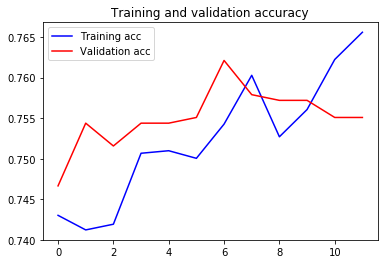

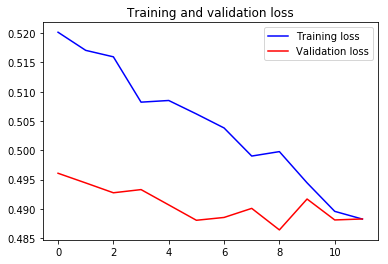

In [135]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [136]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [137]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [138]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.8886623382568359,
 'elapsed_time': 0.16222476959228516}

In [139]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.208253413438797,
 'elapsed_time': 0.16299057006835938}

In [140]:
predict("i don't know what i'm doing")

{'label': 'NEUTRAL',
 'score': 0.6391303539276123,
 'elapsed_time': 0.1585369110107422}

### Confusion Matrix

In [141]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

3563/3563 [==============================] - 0s 77us/step
CPU times: user 295 ms, sys: 24 ms, total: 319 ms
Wall time: 285 ms


In [142]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

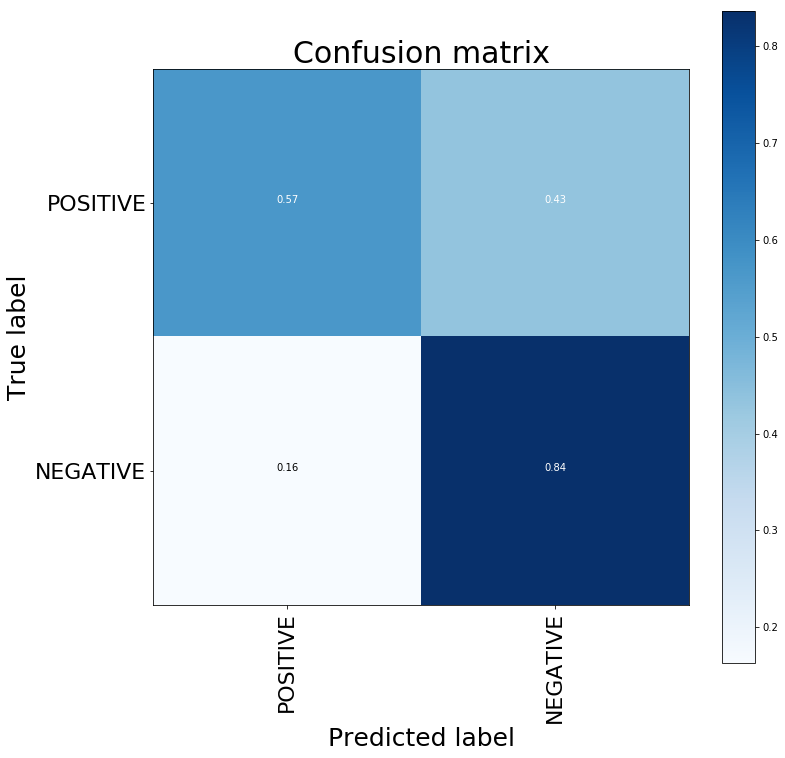

CPU times: user 499 ms, sys: 205 ms, total: 705 ms
Wall time: 399 ms


In [143]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [144]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.67      0.57      0.61      1312
    POSITIVE       0.77      0.84      0.80      2251

   micro avg       0.74      0.74      0.74      3563
   macro avg       0.72      0.70      0.71      3563
weighted avg       0.73      0.74      0.73      3563



### Accuracy Score

In [145]:
accuracy_score(y_test_1d, y_pred_1d)

0.7373000280662363

### Save model

In [146]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2021-09-19 19:41:40,450 : INFO : saving Word2Vec object under model.w2v, separately None
2021-09-19 19:41:40,452 : INFO : not storing attribute vectors_norm
2021-09-19 19:41:40,453 : INFO : not storing attribute cum_table
2021-09-19 19:41:40,490 : INFO : saved model.w2v
